In [1]:
from dataset_test import METRLADatasetLoader;

In [2]:
loader = METRLADatasetLoader();

dataset = loader.get_dataset();

from torch_geometric_temporal.signal import temporal_signal_split
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import A3TGCN

import random
import gc

In [3]:
class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods):
        super(TemporalGNN, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        self.tgnn = A3TGCN(in_channels=node_features,
                           out_channels=32,
                           periods=periods,
                           improved=True)
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(32, periods)

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn(x, edge_index)
        h = F.relu(h)
        h = self.tgnn(x, edge_index)
        h = self.linear(h)
        return h

# GPU support
device = torch.device('cuda') # cuda
subset = 500
gc.collect() # garbage collector
torch.cuda.empty_cache() # cuda

In [4]:
model = TemporalGNN(node_features=2, periods=12).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()

print("Running training...")
for epoch in range(20):
    loss = 0
    for step in range(subset):
        snapshot = train_dataset[(epoch * subset) + step].to(device) # shift snapshot subset every epoch
        # snapshot = train_dataset[random.randrange(train_dataset.snapshot_count)].to(device) # random snapshot
        # Get model predictions
        y_hat = model(snapshot.x, snapshot.edge_index)
        # Mean squared error
        loss = loss + torch.mean((y_hat-snapshot.y)**2)

    loss = loss / (step + 1)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print("Epoch {} train MSE: {:.4f}".format(epoch, loss.item()))

gc.collect()
torch.cuda.empty_cache()

Running training...
Epoch 0 train MSE: 0.8096
Epoch 1 train MSE: 0.4396
Epoch 2 train MSE: 0.6608
Epoch 3 train MSE: 0.9409
Epoch 4 train MSE: 1.8061
Epoch 5 train MSE: 0.6532
Epoch 6 train MSE: 0.5015
Epoch 7 train MSE: 0.5421
Epoch 8 train MSE: 0.4823
Epoch 9 train MSE: 0.2715
Epoch 10 train MSE: 0.2434
Epoch 11 train MSE: 0.6310
Epoch 12 train MSE: 1.0513
Epoch 13 train MSE: 0.2951
Epoch 14 train MSE: 0.6252
Epoch 15 train MSE: 0.5290
Epoch 16 train MSE: 0.4961
Epoch 17 train MSE: 0.4317
Epoch 18 train MSE: 0.4323
Epoch 19 train MSE: 0.4589


In [5]:
model.eval()
loss = 0
horizon = 288

# Store for analysis
predictions = []
labels = []
anomalies = [test_dataset[i].y for i in range(horizon)] # initialized all to actual graph cause i don't know what to do, anomaly isn't actually related to actual graph

for step in range(horizon):
    snapshot = test_dataset[step].to(device)
    # Get predictions
    y_hat = model(snapshot.x, snapshot.edge_index)
    # Mean squared error
    loss = loss + torch.mean((y_hat-snapshot.y)**2)
    if step > 1:
        # acceleration or deviation
        acc = torch.mean(abs((y_hat - predictions[-1]) / predictions[-1]))
        if acc > 1: # random value for now
            anomalies[step] = y_hat # mark point on predicted graph if it exceeds some threshold of acceleration 
    labels.append(snapshot.y)
    predictions.append(y_hat)

loss = loss / (step+1)
loss = loss.item()
print("Test MSE: {:.4f}".format(loss))

gc.collect()
torch.cuda.empty_cache()

Test MSE: 0.8337


In [13]:
import numpy as np

sensor = 123
timestep = 11
preds = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in predictions])
labs  = np.asarray([label[sensor][timestep].detach().cpu().numpy() for label in labels])
anoms = np.asarray([anom[sensor][timestep].detach().cpu().numpy() for anom in anomalies])

<Axes: >

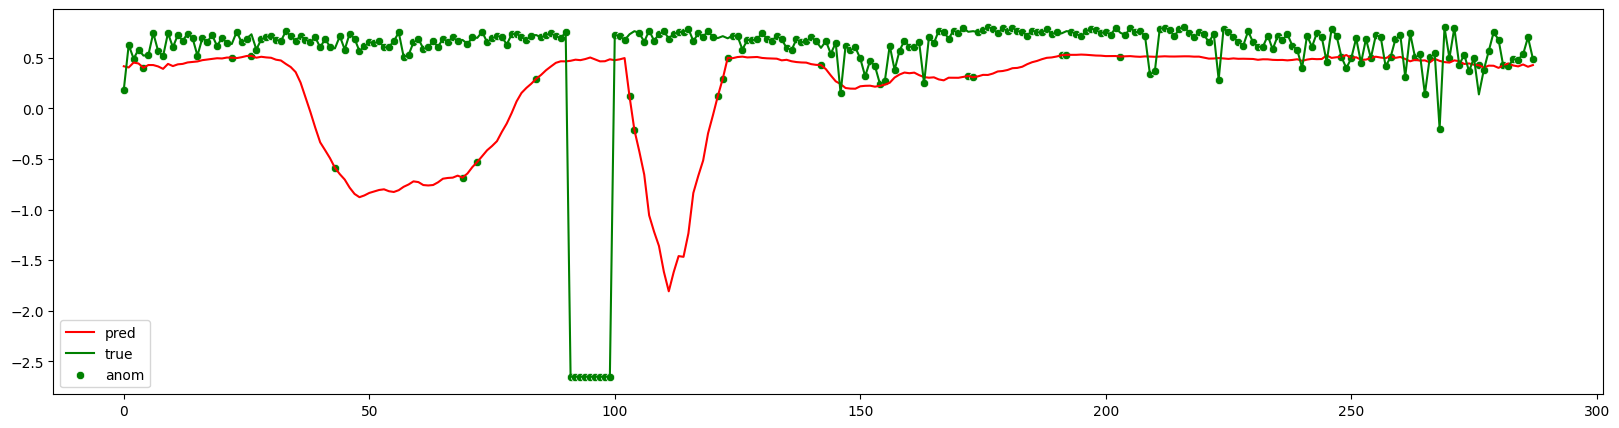

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20,5))
sns.lineplot(data=preds, label="pred", color='red')
sns.lineplot(data=labs, label="true", color='green')
sns.scatterplot(data=anoms, label="anom", color='green') # where points are on actual graph, ignore; on preds, anomaly 